In [1]:
import os
import sys
import time
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import KFold

import torch
import torch.nn as nn

module_path = os.path.abspath(os.path.join('../py-conjugated/'))
if module_path not in sys.path:
    sys.path.append(module_path)
import morphology_networks as net
import model_training as train
import model_testing as test
import physically_informed_loss_functions as pilf
import network_utils as nuts

torch.manual_seed(28)

----------------------------------
# OPV NN7

This model takes in all the available data for the 36 devices with associated atomic force microscopy data and m2py labels.

There are 3 different datasets:
- Tabular data with morphology summaries
- m2py phase and domain labels (2 channels)
- Fast force-distance mapping afm measurements (8 channels)
----------------------------------

In [2]:
data_bucket = 'sagemaker-us-east-2-362637960691'

afm_data_path = 'py-conjugated/raw_data/OPV_npy/total_set/'
afm_test_data_path = 'py-conjugated/raw_data/OPV_npy/test_set/'

m2py_data_path = 'py-conjugated/m2py_labels/new_OPV_labels/total_set/'
m2py_test_data_path = 'py-conjugated/m2py_labels/new_OPV_labels/test_set/'

tabular_data_path = 'py-conjugated/tabular_data/OPV_train/'
tabular_test_data_path = 'py-conjugated/tabular_data/OPV_test/'



In [3]:
%autoreload

CV_afm_dict, CV_afm_label = nuts.load_s3_ims(data_bucket, afm_data_path)
test_afm_dict, test_afm_label = nuts.load_s3_ims(data_bucket, afm_test_data_path)

CV_m2py_dict, CV_m2py_label = nuts.load_s3_ims(data_bucket, m2py_data_path)
test_m2py_dict, test_m2py_label = nuts.load_s3_ims(data_bucket, m2py_test_data_path)

tabular_train_df = nuts.load_s3_df(data_bucket, tabular_data_path)
tabular_test_df = nuts.load_s3_df(data_bucket, tabular_test_data_path)
tabular_df = pd.concat([tabular_train_df, tabular_test_df])


In [4]:
%autoreload

learning_rate = 1e-4
num_epochs = 100

cv_fits = {}

kf = KFold(n_splits = 5)

in_dims = int(tabular_df.shape[1]) #number of x channels

#only need to run split on one of the 3 datasets, then can use the produced
#indeces can be used for all 3 datasets to get the folds
for fold, (train_index, test_index) in enumerate(kf.split(CV_afm_dict, CV_afm_label)):
    print(f'Fold # {fold}')
    print('-----------------------------')
    
    train_dataset = nuts.OPV_CV_total_dataset(CV_afm_dict, CV_afm_label,
                                              CV_m2py_dict, CV_m2py_label,
                                              tabular_train_df, train_index)
    
    test_dataset = nuts.OPV_CV_total_dataset(CV_afm_dict, CV_afm_label,
                                             CV_m2py_dict, CV_m2py_label,
                                             tabular_train_df, test_index)
    
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = len(train_index))
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = len(test_index))
        
    criterion = nn.SmoothL1Loss()
        
    model = net.OPV_total_NN(in_dims)
    model.apply(nuts.init_weights)
    
    cv_fits[fold] = nuts.CV_OPV_total_fit(model, train_loader, test_loader, criterion,
                                    lr = learning_rate, epochs = num_epochs)

    
    

Fold # 0
-----------------------------


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  0


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  2


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  3


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  4


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  5


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  6


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  7


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  8


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  9


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  10


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  11


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  12


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  13


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  14


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  15


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  16


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  17


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  18


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  19


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  20


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  21


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  22


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  23


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  24


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  25


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  26


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  27


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  28


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  29


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  30


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  31


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  32


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  33


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  34


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  35


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  36


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  37


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  38


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  39


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  40


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  41


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  42


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  43


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  44


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  45


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  46


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  47


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  48


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  49


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  50


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  51


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  52


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  53


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  54


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  55


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  56


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  57


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  58


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  59


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  60


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  61


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  62


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  63


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  64


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  65


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  66


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  67


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  68


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  69


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  70


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  71


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  72


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  73


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  74


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  75


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  76


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  77


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  78


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  79


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  80


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  81


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  82


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  83


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  84


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  85


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  86


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  87


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  88


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  89


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  90


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  91


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  92


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  93


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  94


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  95


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  96


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  97


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  98


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  99
Fold # 1
-----------------------------


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  0


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  2


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  3


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  4


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  5


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  6


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  7


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  8


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  9


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  10


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  11


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  12


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  13


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  14


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  15


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  16


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  17


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  18


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  19


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  20


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  21


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  22


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  23


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  24


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  25


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  26


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  27


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  28


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  29


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  30


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  31


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  32


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  33


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  34


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  35


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  36


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  37


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  38


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  39


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  40


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  41


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  42


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  43


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  44


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  45


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  46


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  47


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  48


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  49


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  50


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  51


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  52


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  53


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  54


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  55


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  56


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  57


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  58


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  59


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  60


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  61


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  62


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  63


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  64


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  65


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  66


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  67


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  68


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  69


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  70


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  71


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  72


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  73


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  74


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  75


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  76


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  77


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  78


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  79


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  80


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  81


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  82


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  83


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  84


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  85


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  86


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  87


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  88


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  89


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  90


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  91


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  92


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  93


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  94


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  95


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  96


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  97


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  98


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  99


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Fold # 2
-----------------------------
Finished epoch  0


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  2


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  3


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  4


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  5


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  6


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  7


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  8


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  9


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  10


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  11


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  12


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  13


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  14


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  15


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  16


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  17


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  18


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  19


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  20


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  21


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  22


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  23


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  24


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  25


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  26


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  27


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  28


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  29


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  30


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  31


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  32


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  33


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  34


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  35


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  36


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  37


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  38


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  39


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  40


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  41


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  42


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  43


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  44


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  45


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  46


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  47


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  48


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  49


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  50


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  51


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  52


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  53


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  54


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  55


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  56


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  57


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  58


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  59


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  60


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  61


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  62


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  63


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  64


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  65


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  66


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  67


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  68


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  69


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  70


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  71


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  72


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  73


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  74


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  75


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  76


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  77


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  78


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  79


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  80


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  81


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  82


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  83


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  84


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  85


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  86


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  87


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  88


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  89


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  90


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  91


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  92


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  93


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  94


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  95


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  96


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  97


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  98


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  99
Fold # 3
-----------------------------


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  0


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  2


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  3


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  4


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  5


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  6


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  7


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  8


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  9


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  10


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  11


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  12


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  13


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  14


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  15


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  16


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  17


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  18


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  19


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  20


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  21


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  22


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  23


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  24


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  25


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  26


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  27


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  28


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  29


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  30


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  31


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  32


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  33


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  34


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  35


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  36


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  37


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  38


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  39


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  40


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  41


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  42


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  43


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  44


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  45


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  46


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  47


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  48


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  49


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  50


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  51


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  52


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  53


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  54


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  55


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  56


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  57


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  58


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  59


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  60


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  61


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  62


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  63


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  64


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  65


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  66


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  67


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  68


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  69


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  70


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  71


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  72


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  73


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  74


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  75


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  76


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  77


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  78


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  79


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  80


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  81


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  82


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  83


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  84


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  85


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  86


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  87


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  88


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  89


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  90


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  91


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  92


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  93


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  94


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  95


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  96


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  97


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  98


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  99


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Fold # 4
-----------------------------
Finished epoch  0


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  1


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  2


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  3


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  4


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  5


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  6


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  7


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  8


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  9


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  10


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  11


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  12


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  13


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  14


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  15


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  16


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  17


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  18


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  19


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  20


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  21


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  22


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  23


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  24


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  25


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  26


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  27


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  28


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  29


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  30


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  31


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  32


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  33


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  34


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  35


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  36


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  37


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  38


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  39


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  40


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  41


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  42


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  43


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  44


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  45


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  46


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  47


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  48


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  49


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  50


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  51


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  52


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  53


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  54


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  55


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  56


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  57


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  58


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  59


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  60


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  61


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  62


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  63


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  64


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  65


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  66


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  67


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  68


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  69


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  70


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  71


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  72


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  73


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  74


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  75


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  76


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  77


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  78


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  79


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  80


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  81


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  82


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  83


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  84


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  85


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  86


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  87


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  88


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  89


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  90


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  91


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  92


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  93


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  94


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  95


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  96


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  97


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  98


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:813: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Finished epoch  99


In [ ]:
cv_fits

In [5]:
#with open('s3://sagemaker-us-east-2-362637960691/20200722_CNN3_hpo_results.json', 'w') as fp:
with open('../ipynb/Networks/json/20201030_OPVNN7_CV_AdamW_opt_amsgrad_lr1e-4.json', 'w') as fp:
    json.dump(cv_fits, fp)

In [6]:
with open('../ipynb/Networks/json/20201030_OPVNN7_CV_AdamW_opt_amsgrad_lr1e-4.json') as fp:
    data = json.load(fp)
    
data['0'].keys()

dict_keys(['lr', 'best_loss_epoch', 'best_acc_epoch', 'best_r2_epoch', 'pce_loss', 'voc_loss', 'jsc_loss', 'ff_loss', 'test_losses', 'pce_acc', 'voc_acc', 'jsc_acc', 'ff_acc', 'test_accs', 'pce_r2', 'voc_r2', 'jsc_r2', 'ff_r2', 'test_r2s', 'train_pce_loss', 'train_voc_loss', 'train_jsc_loss', 'train_ff_loss'])

In [7]:
def plot_fit_results(fit_dict):
    lr = float(fit_dict['lr'])
    best_loss_epoch = int(fit_dict['best_loss_epoch'])
    best_acc_epoch = int(fit_dict['best_acc_epoch'])
    best_r2_epoch = int(fit_dict['best_r2_epoch'])
    
    test_loss = [float(i) for i in fit_dict['test_losses']]
    pce_loss = [float(i) for i in fit_dict['pce_loss']]
    voc_loss = [float(i) for i in fit_dict['voc_loss']]
    jsc_loss = [float(i) for i in fit_dict['jsc_loss']]
    ff_loss = [float(i) for i in fit_dict['ff_loss']]
    
    test_acc = [float(i) for i in fit_dict['test_accs']]
    pce_acc = [float(i) for i in fit_dict['pce_acc']]
    voc_acc = [float(i) for i in fit_dict['voc_acc']]
    jsc_acc = [float(i) for i in fit_dict['jsc_acc']]
    ff_acc = [float(i) for i in fit_dict['ff_acc']]
    
    test_r2 = [float(i) for i in fit_dict['test_r2s']]
    pce_r2 = [float(i) for i in fit_dict['pce_r2']]
    voc_r2 = [float(i) for i in fit_dict['voc_r2']]
    jsc_r2 = [float(i) for i in fit_dict['jsc_r2']]
    ff_r2 = [float(i) for i in fit_dict['ff_r2']]
    
    train_pce_loss = [float(i) for i in fit_dict['train_pce_loss']]
    train_voc_loss = [float(i) for i in fit_dict['train_voc_loss']]
    train_jsc_loss = [float(i) for i in fit_dict['train_jsc_loss']]
    train_ff_loss = [float(i) for i in fit_dict['train_ff_loss']]

    epochs = np.arange(0, (len(test_loss)), 1)
    
    best_pce_index = pce_acc.index(min(pce_acc[:100]))
    best_voc_index = voc_acc.index(min(voc_acc[:100]))
    best_jsc_index = jsc_acc.index(min(jsc_acc[:100]))
    best_ff_index = ff_acc.index(min(ff_acc[:100]))
    
#     best_pce_loss = pce_loss[best_pce_index]
#     best_voc_loss = voc_loss[best_voc_index]
#     best_jsc_loss = jsc_loss[best_jsc_index]
#     best_ff_loss = ff_loss[best_ff_index]
    
#     best_pce_acc = pce_acc[best_pce_index]
#     best_voc_acc = voc_acc[best_voc_index]
#     best_jsc_acc = jsc_acc[best_jsc_index]
#     best_ff_acc = ff_acc[best_ff_index]
    
#     best_pce_r2 = pce_r2[best_pce_index]
#     best_voc_r2 = voc_r2[best_voc_index]
#     best_jsc_r2 = jsc_r2[best_jsc_index]
#     best_ff_r2 = ff_r2[best_ff_index]
    
    print(f"PCE epoch: {best_pce_index}")
    print(f"Voc epoch: {best_voc_index}")
    print(f"Jsc epoch: {best_jsc_index}")
    print(f"FF epoch: {best_ff_index}")
    
#     print(f"PCE Loss: {best_pce_loss}")
#     print(f"Voc Loss: {best_voc_loss}")
#     print(f"Jsc Loss: {best_jsc_loss}")
#     print(f"FF Loss: {best_ff_loss}")
    
#     print(f"PCE MAPE: {best_pce_acc}")
#     print(f"Voc MAPE: {best_voc_acc}")
#     print(f"Jsc MAPE: {best_jsc_acc}")
#     print(f"FF MAPE: {best_ff_acc}")
    
#     print(f"PCE R2: {best_pce_r2}")
#     print(f"Voc R2: {best_voc_r2}")
#     print(f"Jsc R2: {best_jsc_r2}")
#     print(f"FF R2: {best_ff_r2}")

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (12, 6))
    ax1.plot(epochs, pce_loss, c = 'r', label = 'pce loss')
    ax1.plot(epochs, voc_loss, c = 'g', label = 'voc loss')
    ax1.plot(epochs, jsc_loss, c = 'b', label = 'jsc loss')
    ax1.plot(epochs, ff_loss, c = 'c', label = 'ff loss')
#     ax1.plot(epochs, test_loss, c = 'k', label = 'total loss')
    ax1.plot(epochs, train_pce_loss, c = 'r', linestyle = '-.', label = 'pce train loss')
    ax1.plot(epochs, train_voc_loss, c = 'g', linestyle = '-.', label = 'voc train loss')
    ax1.plot(epochs, train_jsc_loss, c = 'b', linestyle = '-.', label = 'jsc train loss')
#     ax1.plot(epochs, train_ff_loss, c = 'c', linestyle = '-.', label = 'ff train loss')
    ax1.scatter(best_loss_epoch, min(test_loss[:100]), s = 64, c = 'c')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Mean Squared Error Loss')
    ax1.legend(loc = 'best')
    ax1.set_title(f'MSE Loss with lr = {lr}')

    ax2.plot(epochs, pce_acc, c = 'r', label = 'pce acc')
    ax2.plot(epochs, voc_acc, c = 'g', label = 'voc acc')
    ax2.plot(epochs, jsc_acc, c = 'b', label = 'jsc acc')
    ax2.plot(epochs, ff_acc, c = 'c', label = 'ff acc')
#     ax2.plot(epochs, test_acc, c = 'k', label = 'total acc')
    ax2.scatter(best_acc_epoch, min(test_acc[:100]), s = 64, c = 'c')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Mean Absolute Percent Error')
    ax2.legend(loc = 'best')
    ax2.set_title(f'MAPE with lr = {lr}')

    ax3.plot(epochs, pce_r2, c = 'r', label = 'pce R$^2$')
    ax3.plot(epochs, voc_r2, c = 'g', label = 'voc R$^2$')
    ax3.plot(epochs, jsc_r2, c = 'b', label = 'jsc R$^2$')
    ax3.plot(epochs, ff_r2, c = 'c', label = 'ff R$^2$')
#     ax3.plot(epochs, test_r2, c = 'k', label = 'total R$^2$')
    ax3.scatter(best_r2_epoch, max(test_r2[:100]), s = 64, c = 'c')
    ax3.set_xlabel('Epochs')
    ax3.set_ylabel('R$^2$')
    ax3.legend(loc = 'best')
    ax3.set_title(f'R$^2$ with lr = {lr}')
    
    plt.tight_layout()
    plt.show()

def report_metrics(fit_dict):
    lr = float(fit_dict['lr'])
    best_loss_epoch = int(fit_dict['best_loss_epoch'])
    best_acc_epoch = int(fit_dict['best_acc_epoch'])
    best_r2_epoch = int(fit_dict['best_r2_epoch'])
    
    test_loss = [float(i) for i in fit_dict['test_losses']]
    pce_loss = [float(i) for i in fit_dict['pce_loss']]
    voc_loss = [float(i) for i in fit_dict['voc_loss']]
    jsc_loss = [float(i) for i in fit_dict['jsc_loss']]
    ff_loss = [float(i) for i in fit_dict['ff_loss']]
    
    test_acc = [float(i) for i in fit_dict['test_accs']]
    pce_acc = [float(i) for i in fit_dict['pce_acc']]
    voc_acc = [float(i) for i in fit_dict['voc_acc']]
    jsc_acc = [float(i) for i in fit_dict['jsc_acc']]
    ff_acc = [float(i) for i in fit_dict['ff_acc']]
    
    test_r2 = [float(i) for i in fit_dict['test_r2s']]
    pce_r2 = [float(i) for i in fit_dict['pce_r2']]
    voc_r2 = [float(i) for i in fit_dict['voc_r2']]
    jsc_r2 = [float(i) for i in fit_dict['jsc_r2']]
    ff_r2 = [float(i) for i in fit_dict['ff_r2']]
    
    train_pce_loss = [float(i) for i in fit_dict['train_pce_loss']]
    train_voc_loss = [float(i) for i in fit_dict['train_voc_loss']]
    train_jsc_loss = [float(i) for i in fit_dict['train_jsc_loss']]
    train_ff_loss = [float(i) for i in fit_dict['train_ff_loss']]
    
    best_pce_index = pce_acc.index(min(pce_acc[:100]))
    best_voc_index = voc_acc.index(min(voc_acc[:100]))
    best_jsc_index = jsc_acc.index(min(jsc_acc[:100]))
    best_ff_index = ff_acc.index(min(ff_acc[:100]))
    
    best_pce_loss = pce_loss[best_pce_index]
    best_voc_loss = voc_loss[best_voc_index]
    best_jsc_loss = jsc_loss[best_jsc_index]
    best_ff_loss = ff_loss[best_ff_index]
    
    losses = [best_pce_loss, best_voc_loss, best_jsc_loss, best_ff_loss]
    
    best_pce_acc = pce_acc[best_pce_index]
    best_voc_acc = voc_acc[best_voc_index]
    best_jsc_acc = jsc_acc[best_jsc_index]
    best_ff_acc = ff_acc[best_ff_index]
    
    accs = [best_pce_acc, best_voc_acc, best_jsc_acc, best_ff_acc]

    best_pce_r2 = pce_r2[best_pce_index]
    best_voc_r2 = voc_r2[best_voc_index]
    best_jsc_r2 = jsc_r2[best_jsc_index]
    best_ff_r2 = ff_r2[best_ff_index]
    
    r2s = [best_pce_r2, best_voc_r2, best_jsc_r2, best_ff_r2]
    
    return losses, accs, r2s

PCE epoch: 99
Voc epoch: 55
Jsc epoch: 63
FF epoch: 88


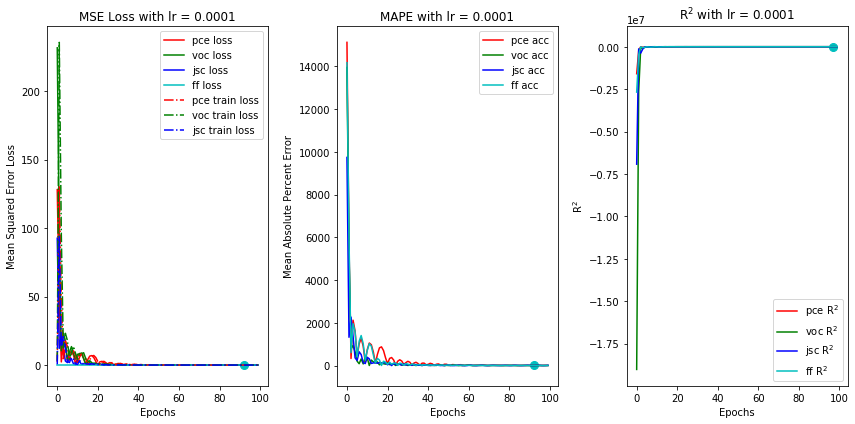

PCE epoch: 40
Voc epoch: 36
Jsc epoch: 61
FF epoch: 94


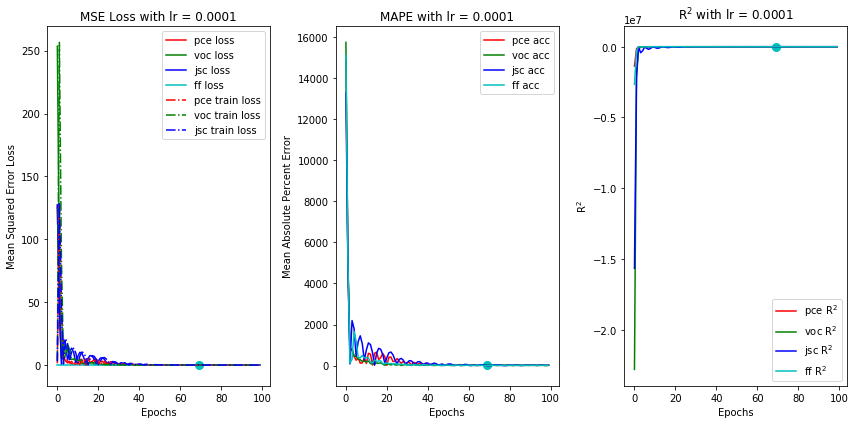

PCE epoch: 64
Voc epoch: 77
Jsc epoch: 72
FF epoch: 45


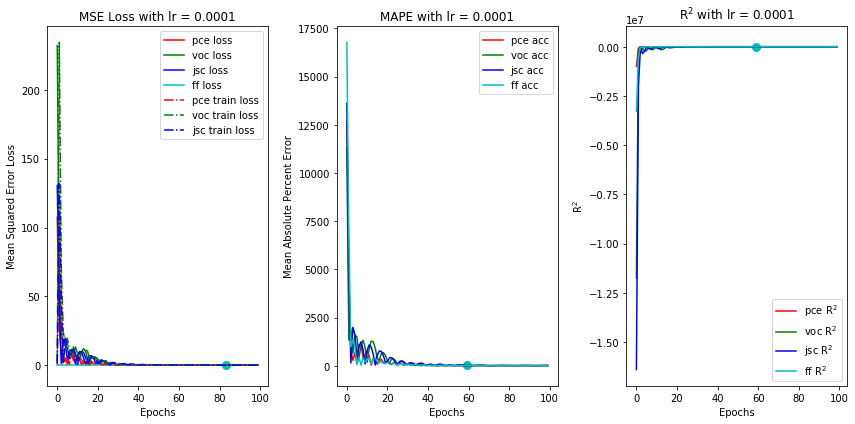

PCE epoch: 48
Voc epoch: 73
Jsc epoch: 63
FF epoch: 55


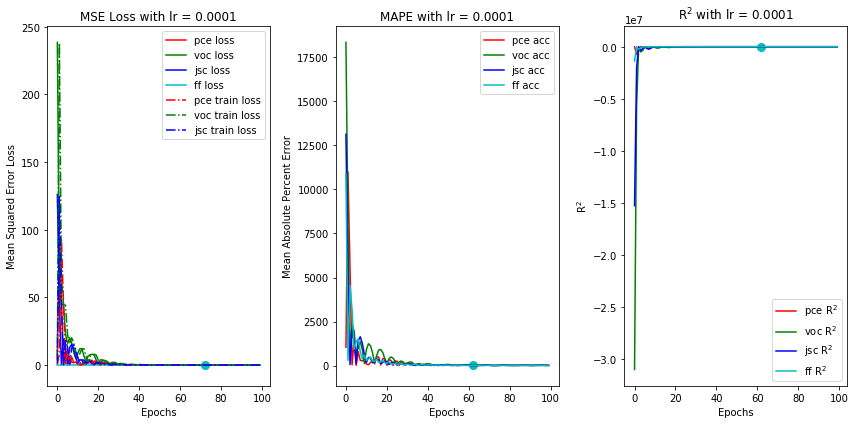

PCE epoch: 94
Voc epoch: 83
Jsc epoch: 52
FF epoch: 87


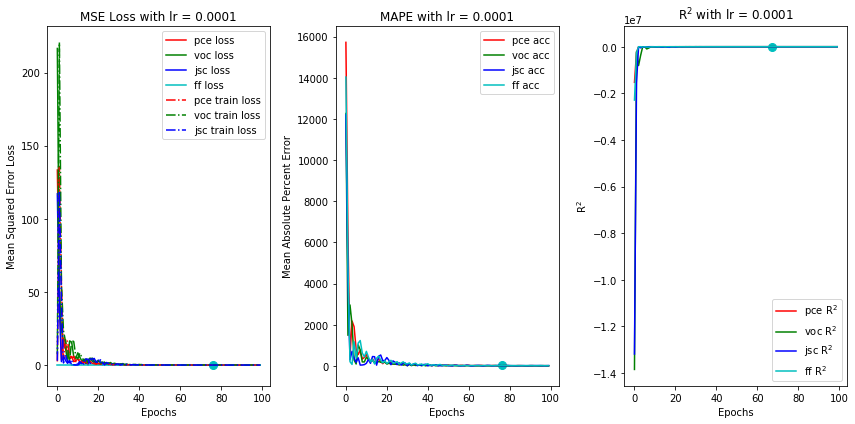

In [8]:
%autoreload

loss_summary = {}
acc_summary = {}
r2_summary = {}

pce_loss = []
pce_acc = []
pce_r2 = []
voc_loss = []
voc_acc = []
voc_r2 = []
jsc_loss = []
jsc_acc = []
jsc_r2 = []
ff_loss = []
ff_acc = []
ff_r2 = []


for key, fit_dict in data.items():
    plot_fit_results(fit_dict)
    losses, accs, r2s = report_metrics(fit_dict)
    
    pce_loss.append(losses[0])
    pce_acc.append(accs[0])
    pce_r2.append(r2s[0])
    
    voc_loss.append(losses[1])
    voc_acc.append(accs[1])
    voc_r2.append(r2s[1])
    
    jsc_loss.append(losses[2])
    jsc_acc.append(accs[2])
    jsc_r2.append(r2s[2])
    
    ff_loss.append(losses[3])
    ff_acc.append(accs[3])
    ff_r2.append(r2s[3])
    
    
loss_summary['PCE Worst'] = max(pce_loss)
loss_summary['PCE Avg'] = sum(pce_loss)/len(pce_loss)
loss_summary['PCE Best'] = min(pce_loss)

loss_summary['Voc Worst'] = max(voc_loss)
loss_summary['Voc Avg'] = sum(voc_loss)/len(voc_loss)
loss_summary['Voc Best'] = min(voc_loss)

loss_summary['Jsc Worst'] = max(jsc_loss)
loss_summary['Jsc Avg'] = sum(jsc_loss)/len(jsc_loss)
loss_summary['Jsc Best'] = min(jsc_loss)

loss_summary['FF Worst'] = max(ff_loss)
loss_summary['FF Avg'] = sum(ff_loss)/len(ff_loss)
loss_summary['FF Best'] = min(ff_loss)

acc_summary['PCE Worst'] = max(pce_acc)
acc_summary['PCE Avg'] = sum(pce_acc)/len(pce_acc)
acc_summary['PCE Best'] = min(pce_acc)

acc_summary['Voc Worst'] = max(voc_acc)
acc_summary['Voc Avg'] = sum(voc_acc)/len(voc_acc)
acc_summary['Voc Best'] = min(voc_acc)

acc_summary['Jsc Worst'] = max(jsc_acc)
acc_summary['Jsc Avg'] = sum(jsc_acc)/len(jsc_acc)
acc_summary['Jsc Best'] = min(jsc_acc)

acc_summary['FF Worst'] = max(ff_acc)
acc_summary['FF Avg'] = sum(ff_acc)/len(ff_acc)
acc_summary['FF Best'] = min(ff_acc)

r2_summary['PCE Worst'] = min(pce_r2)
r2_summary['PCE Avg'] = sum(pce_r2)/len(pce_r2)
r2_summary['PCE Best'] = max(pce_r2)

r2_summary['Voc Worst'] = min(voc_r2)
r2_summary['Voc Avg'] = sum(voc_r2)/len(voc_r2)
r2_summary['Voc Best'] = max(voc_r2)

r2_summary['Jsc Worst'] = min(jsc_r2)
r2_summary['Jsc Avg'] = sum(jsc_r2)/len(jsc_r2)
r2_summary['Jsc Best'] = max(jsc_r2)

r2_summary['FF Worst'] = min(ff_r2)
r2_summary['FF Avg'] = sum(ff_r2)/len(ff_r2)
r2_summary['FF Best'] = max(ff_r2)

In [9]:
loss_summary

{'PCE Worst': 0.006021422799676657,
 'PCE Avg': 0.005827368702739477,
 'PCE Best': 0.005218353122472763,
 'Voc Worst': 0.030316620162921026,
 'Voc Avg': 0.010826031328178942,
 'Voc Best': 0.003106673597358167,
 'Jsc Worst': 0.0007897362811490893,
 'Jsc Avg': 0.0006627331604249775,
 'Jsc Best': 0.0005689325043931603,
 'FF Worst': 0.0,
 'FF Avg': 0.0,
 'FF Best': 0.0}

In [10]:
acc_summary

{'PCE Worst': 10.723480224609375,
 'PCE Avg': 10.000678443908692,
 'PCE Best': 8.930706024169922,
 'Voc Worst': 2.8592121601104736,
 'Voc Avg': 2.550617504119873,
 'Voc Best': 2.3004884719848633,
 'Jsc Worst': 2.850372791290283,
 'Jsc Avg': 2.5623593807220457,
 'Jsc Best': 2.2623214721679688,
 'FF Worst': 15.793980598449707,
 'FF Avg': 8.6715838432312,
 'FF Best': 6.293910980224609}

In [11]:
r2_summary

{'PCE Worst': -0.05909685743821158,
 'PCE Avg': 0.013085323910780499,
 'PCE Best': 0.07963917796046383,
 'Voc Worst': -0.6880797958229985,
 'Voc Avg': -0.22631106832154516,
 'Voc Best': 0.0613616694099991,
 'Jsc Worst': -0.2230214113702358,
 'Jsc Avg': 0.08232188962000456,
 'Jsc Best': 0.5675129853994917,
 'FF Worst': -2.354090198012647,
 'FF Avg': -0.5043509172197844,
 'FF Best': 0.2943861332020369}